In [ ]:
# データの分割手法

In [ ]:
!pip install -q wget sweetviz optuna japanize-matplotlib

# wget：　データダウンロード
# sweetviz: 可視化
# optuna: ハイパラの最適化
# japanize-matplotlib：　図に日本語の挿入

In [ ]:
# データのダウンロード
import wget

# 前処理
import pandas as pd
import numpy as np

# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import sweetviz as sv

# モデルの評価など
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

# モデル（lightgbm）
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna.integration.lightgbm as lgb_opt

# ハイパラの最適化
import optuna

# warningの表示を消す
import warnings
warnings.simplefilter("ignore")

In [ ]:
# データのダウンロード（abaloan）
wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data")


'abalone (1).data'

In [ ]:
# 読み込み
df = pd.read_csv("abalone.data",
                 header=None,
                 names=[
                     "性別",
                     "殻の長さ（mm）",
                     "殻の高さ（mm）",
                     "身の高さ(mm)",
                     "全体の重さ（mm）",
                     "身の重さ(g)",
                     "血抜き後の腸の重さ(g)",
                     "乾燥後の殻の重さ(g)",
                     "殻の年輪の数", # 目的変数
                 ])

# 性別を整数に変換
ord = OrdinalEncoder()
df["性別"] = ord.fit_transform(df[["性別"]])

df.head()

,性別,殻の長さ（mm）,殻の高さ（mm）,身の高さ(mm),全体の重さ（mm）,身の重さ(g),血抜き後の腸の重さ(g),乾燥後の殻の重さ(g),殻の年輪の数
0,2.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
# 分割（ホールドアウト法）
df_train = df[:int(len(df)*0.7)]
df_test = df[int(len(df)*0.7):]
print("学習データの数：" + str(len(df_train)))
print("テストデータの数："+ str(len(df_test)))

学習データの数：2923
テストデータの数：1254


In [ ]:
df_train.columns

Index(['性別', '殻の長さ（mm）', '殻の高さ（mm）', '身の高さ(mm)', '全体の重さ（mm）', '身の重さ(g)',
       '血抜き後の腸の重さ(g)', '乾燥後の殻の重さ(g)', '殻の年輪の数'],
      dtype='object')

In [ ]:
df_train["train/valid/test"] = "train" # 訓練データ
df_test["train/valid/test"] = "test"

In [ ]:
df_train.columns

Index(['性別', '殻の長さ（mm）', '殻の高さ（mm）', '身の高さ(mm)', '全体の重さ（mm）', '身の重さ(g)',
       '血抜き後の腸の重さ(g)', '乾燥後の殻の重さ(g)', '殻の年輪の数', 'train/valid/test'],
      dtype='object')

In [ ]:
my_report = sv.compare([df_train, # 訓練データ
                           "Train"], # 表示名
                         [df_test, # テストデータ
                          "Test"]) #

                                             |          | [  0%]   00:00 -> (? left)


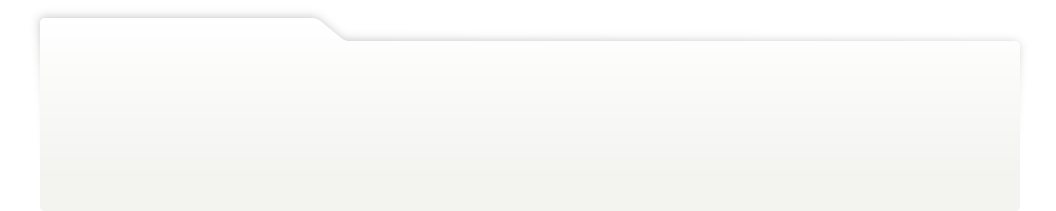
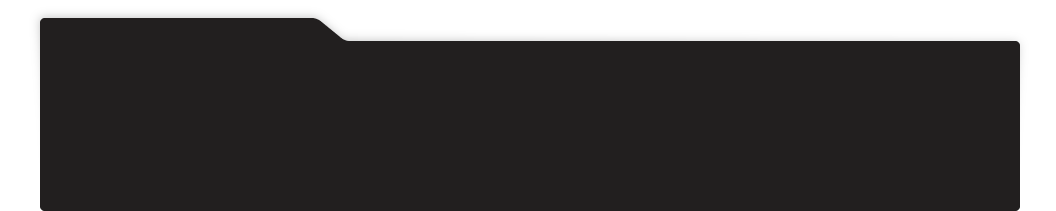
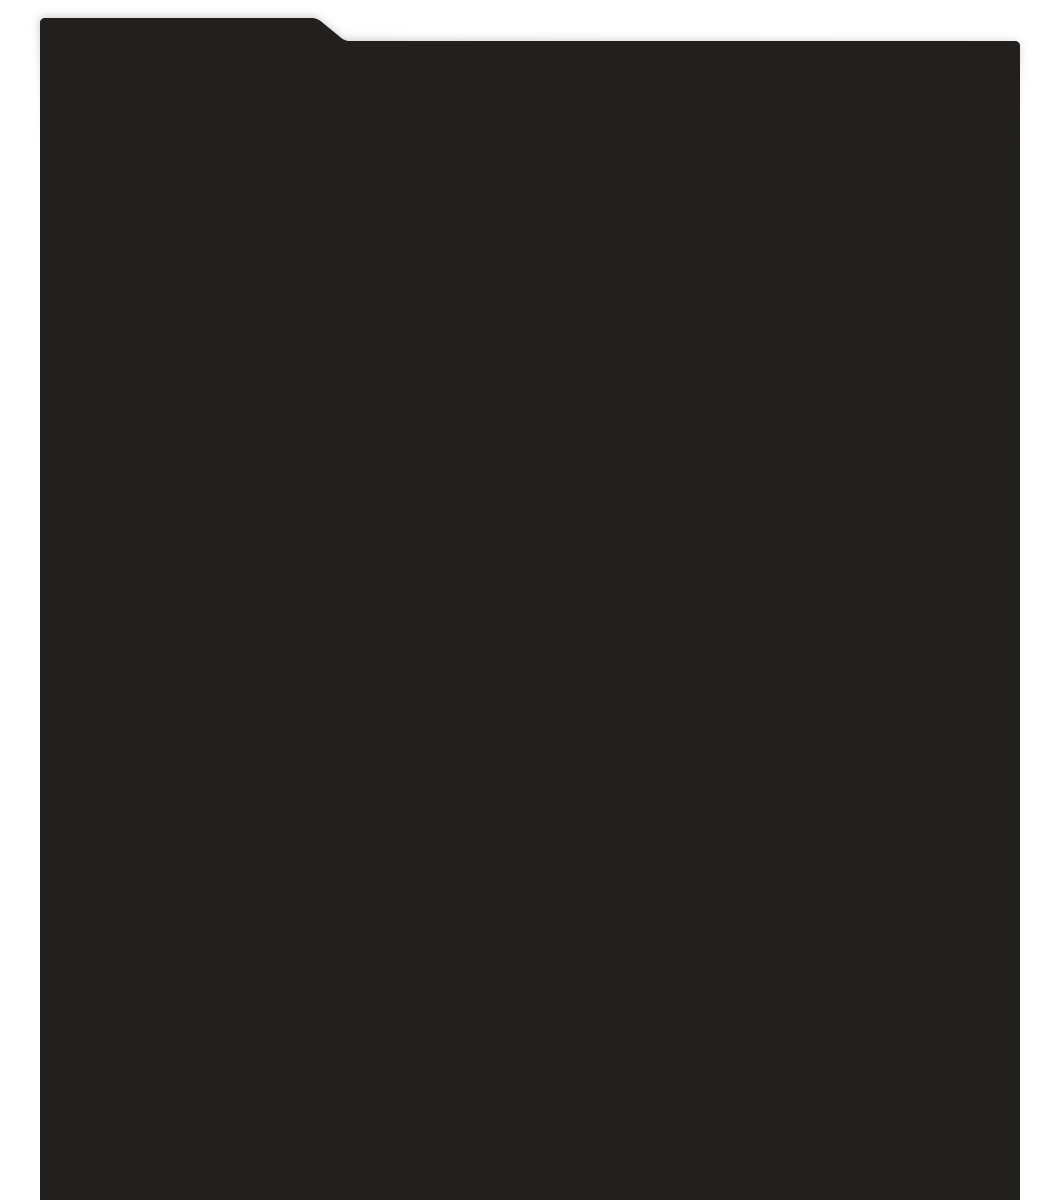
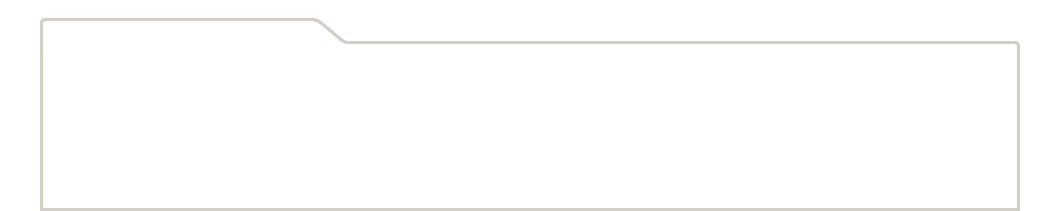
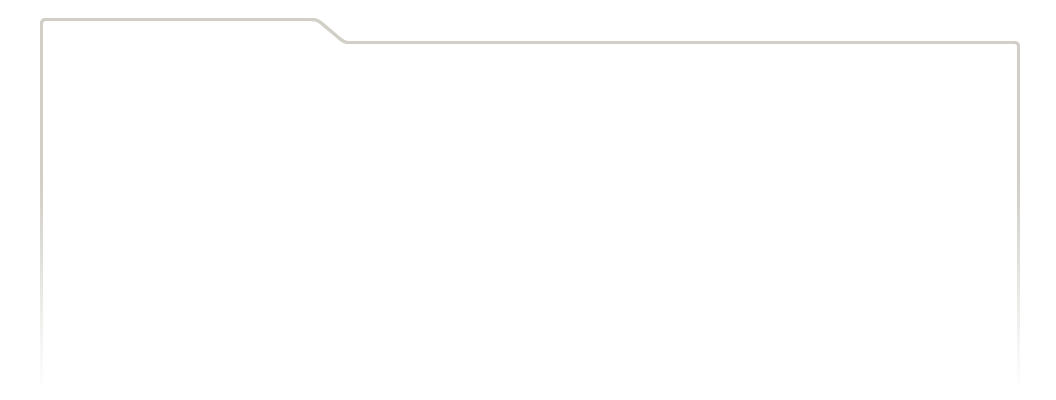
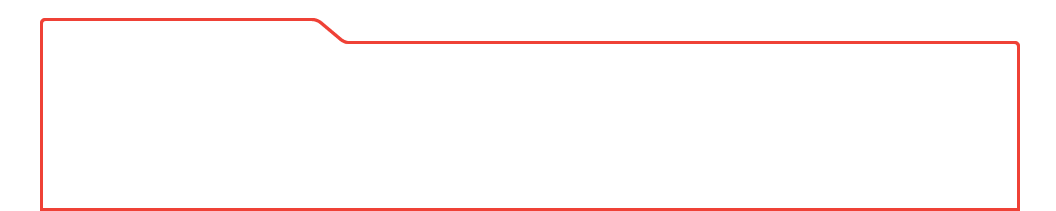
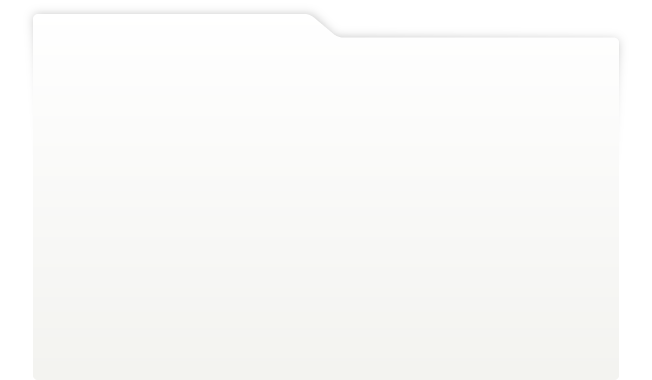
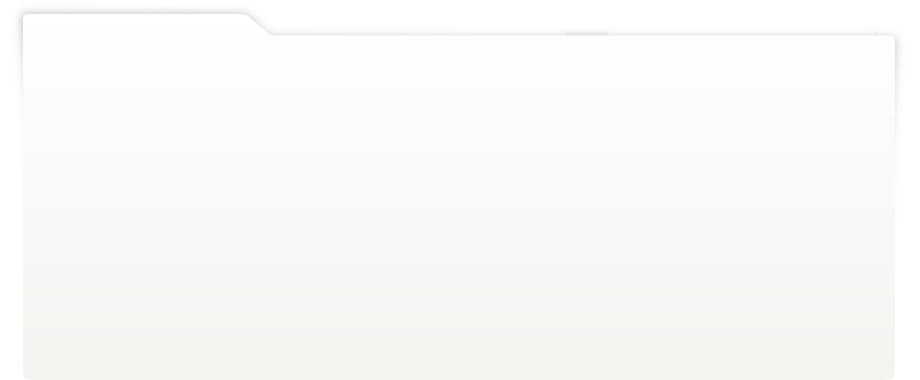
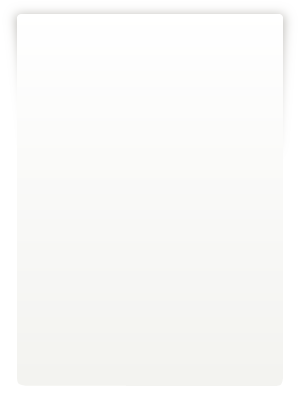
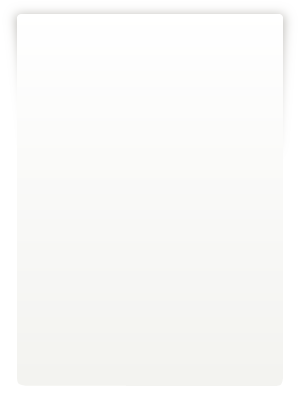
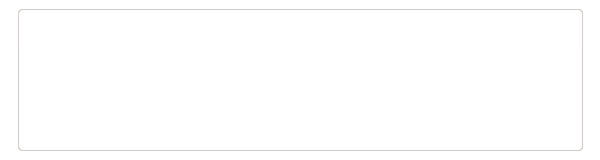
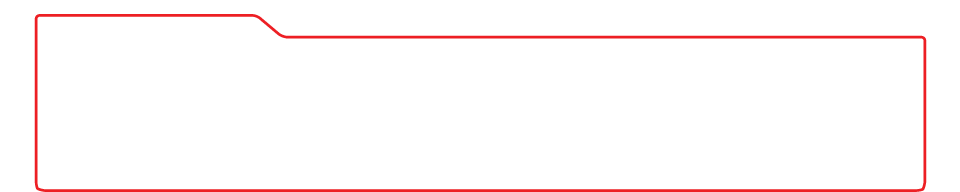
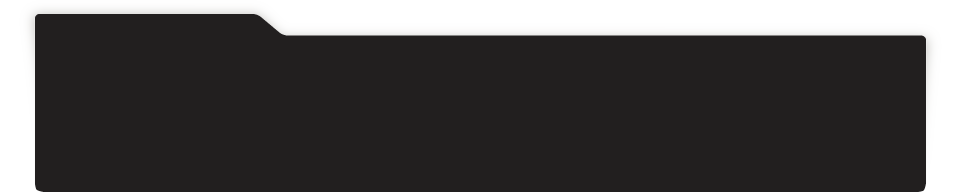
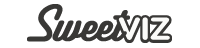
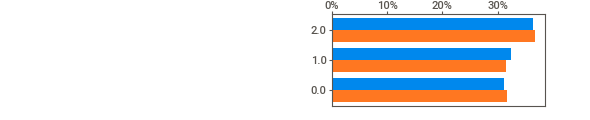
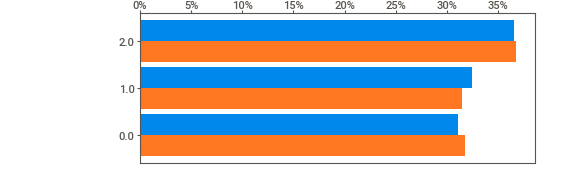
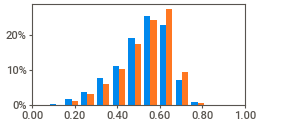
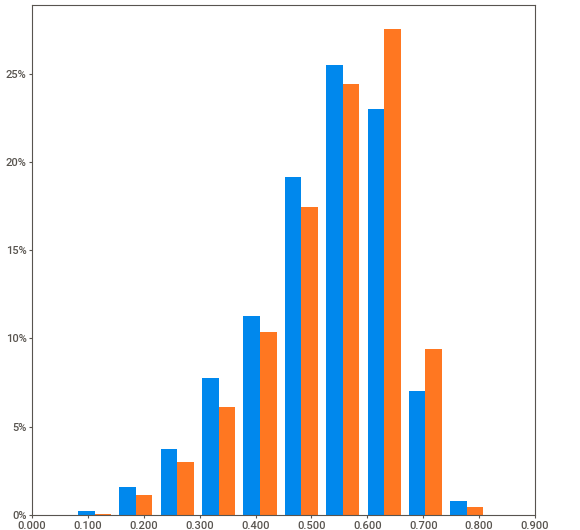
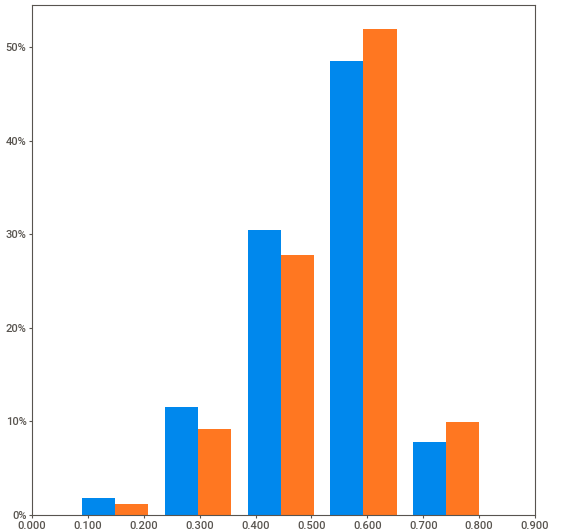
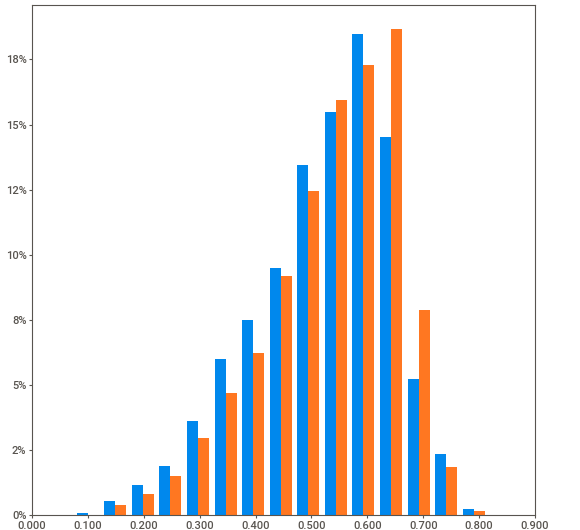
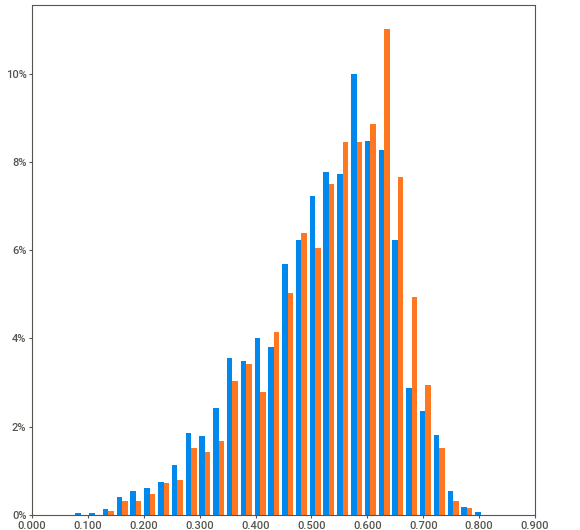
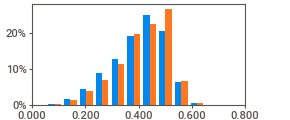
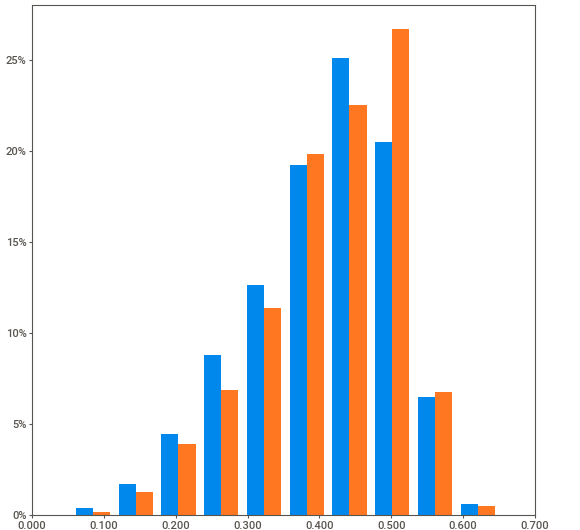
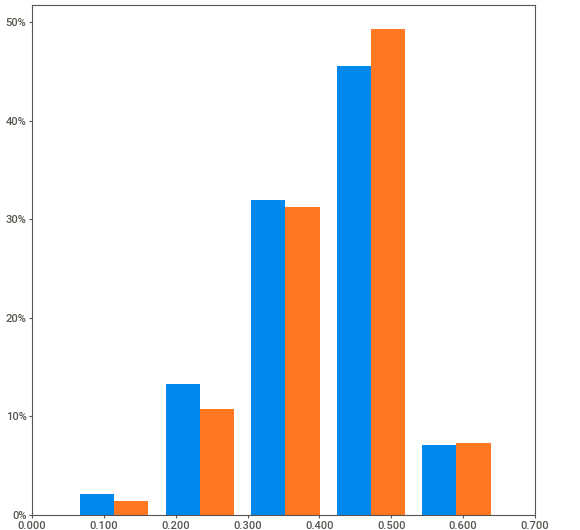
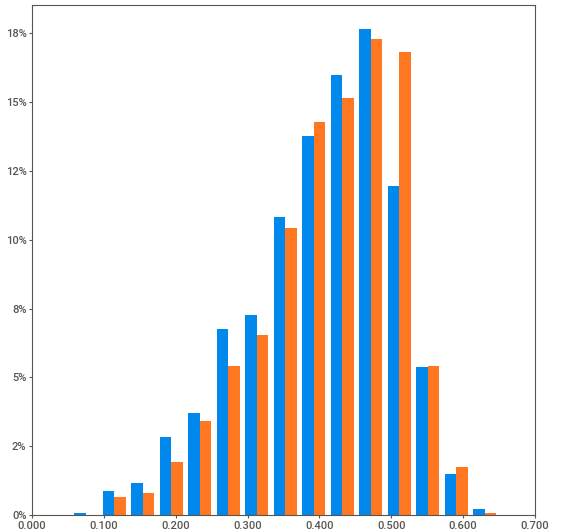
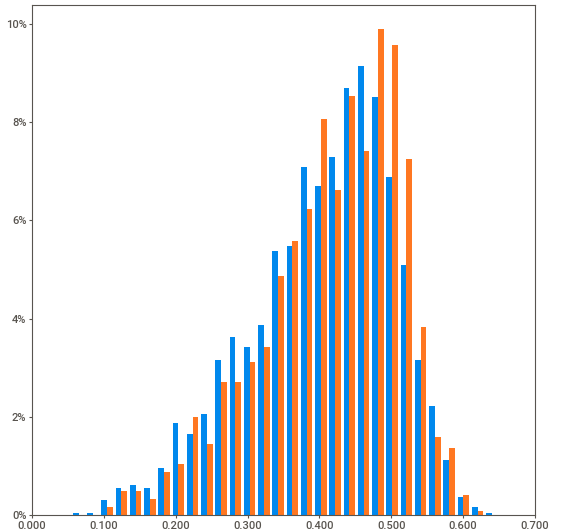
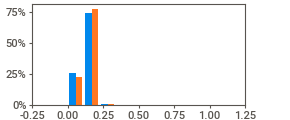
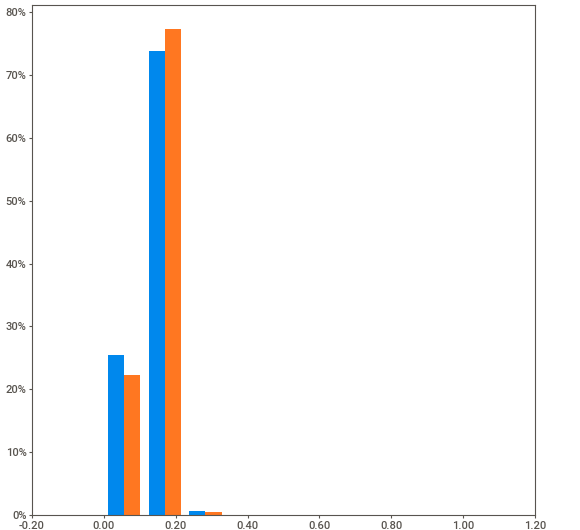
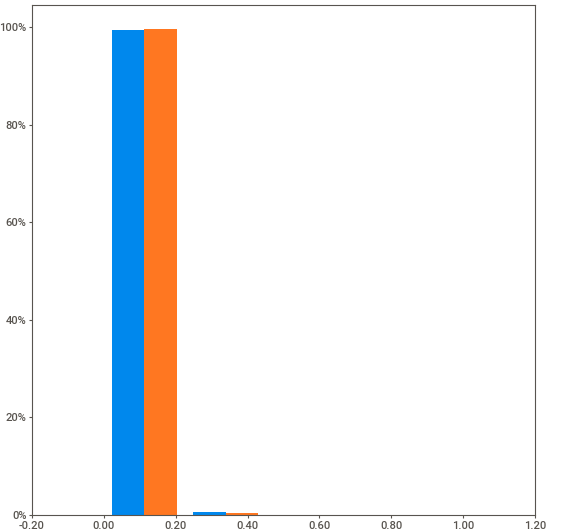
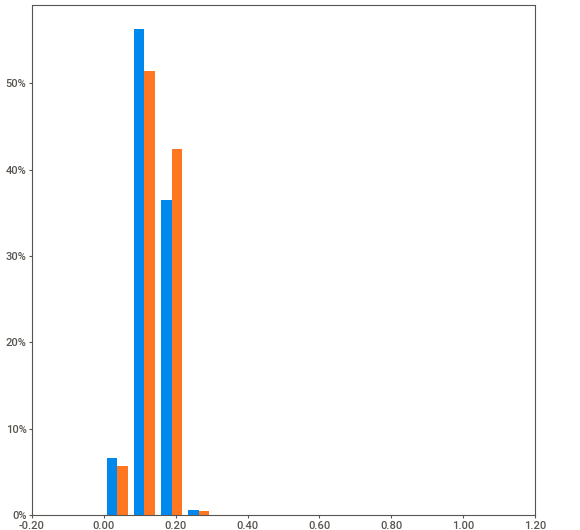
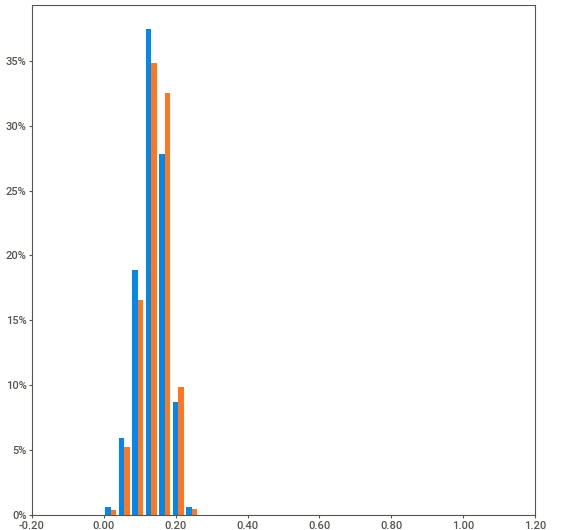
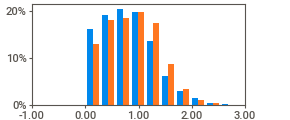
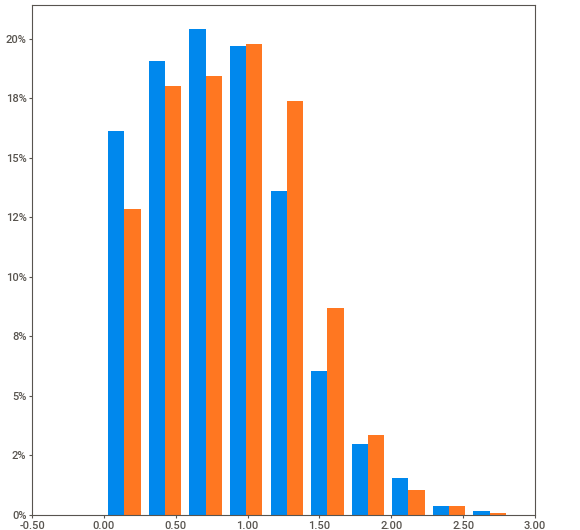
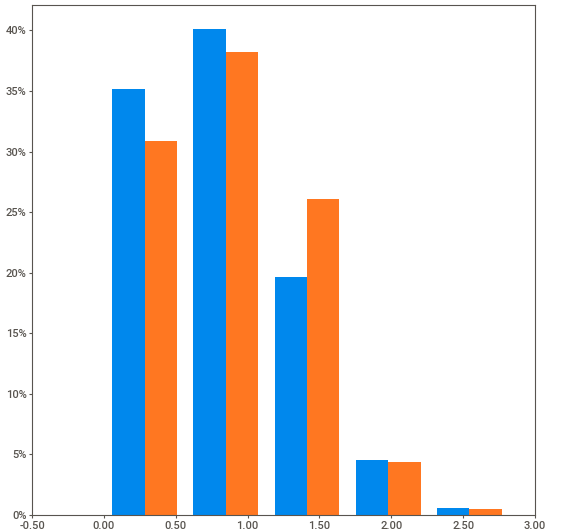
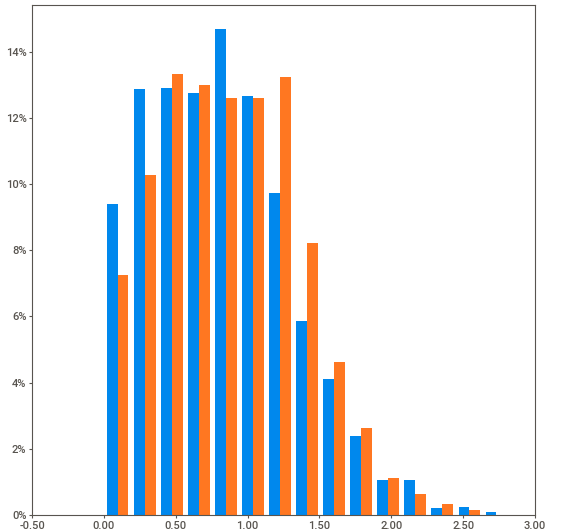
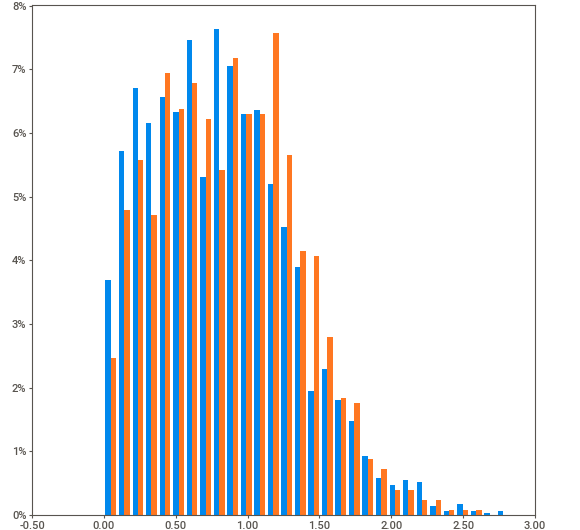
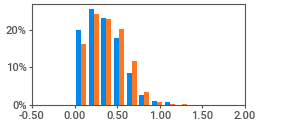
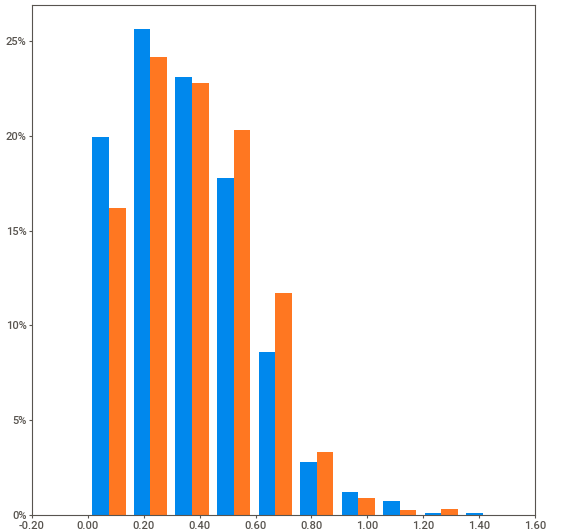
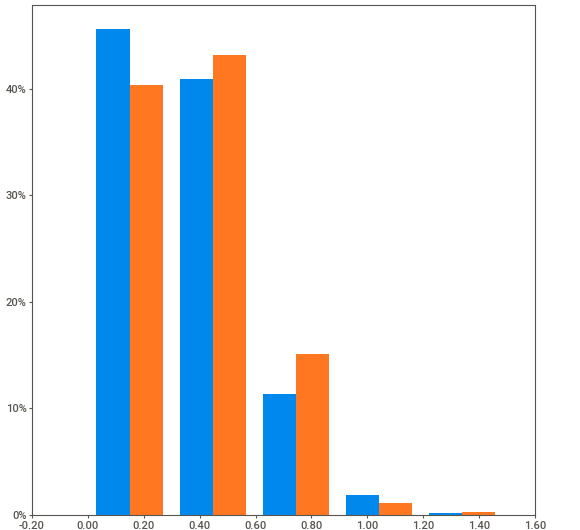
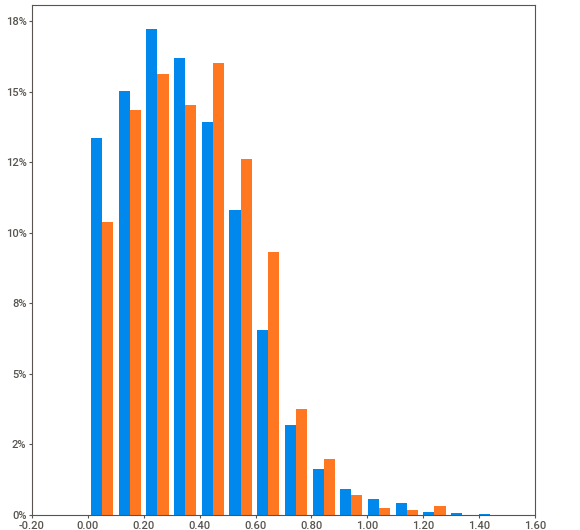
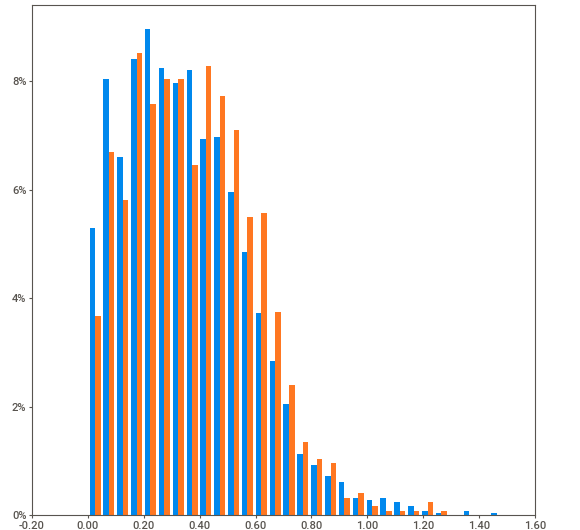
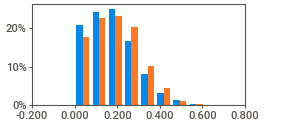
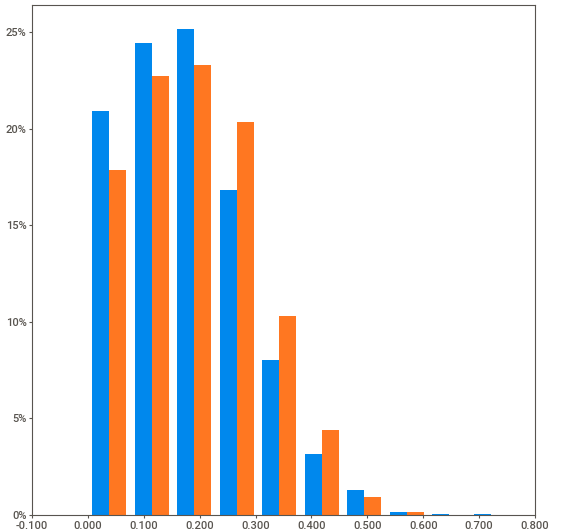
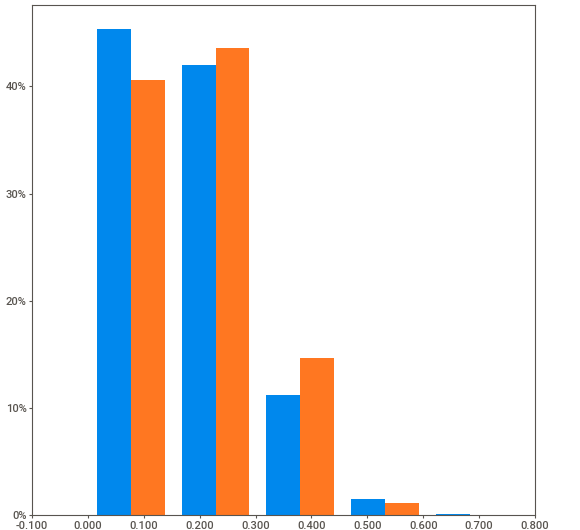
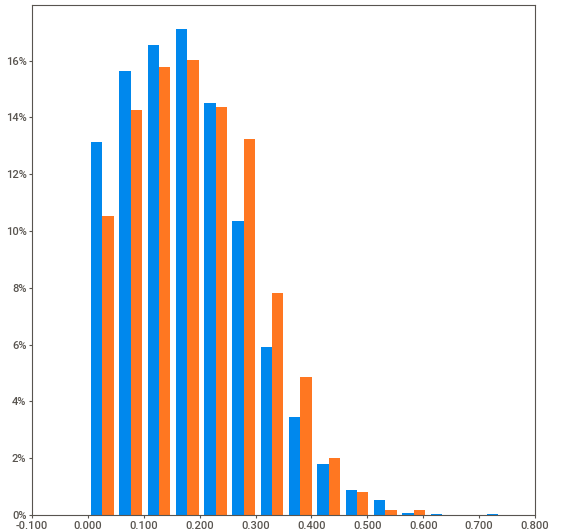
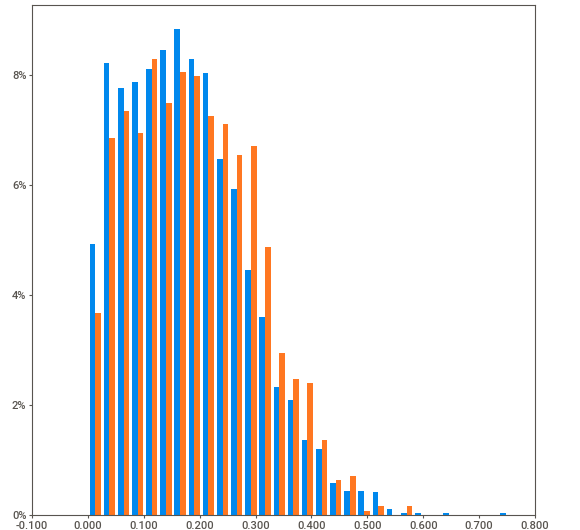
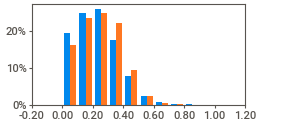
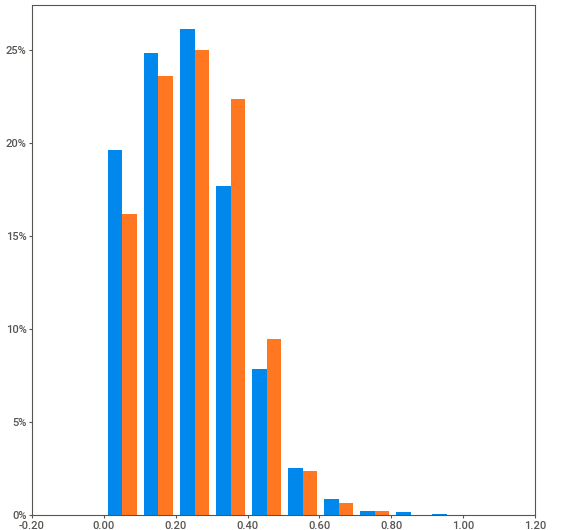
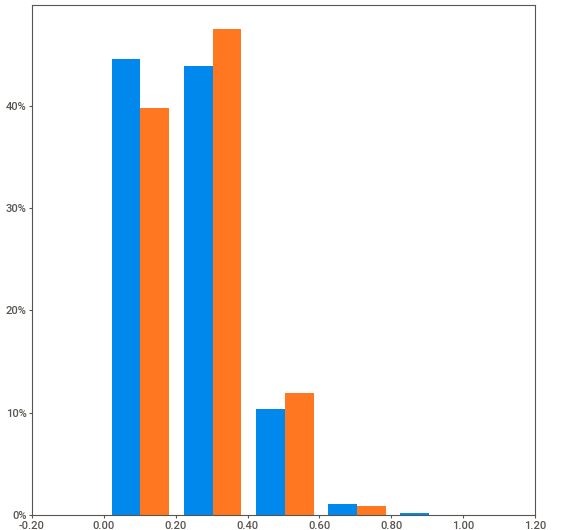
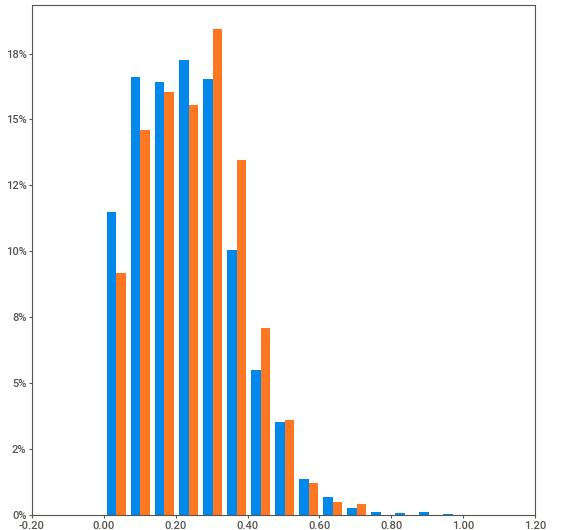
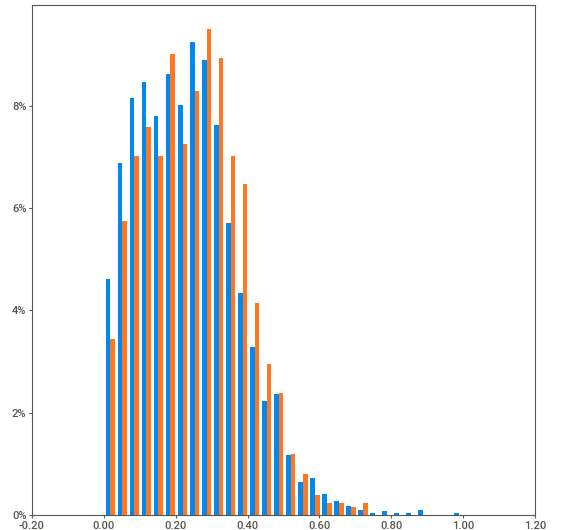
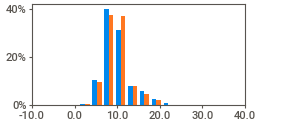
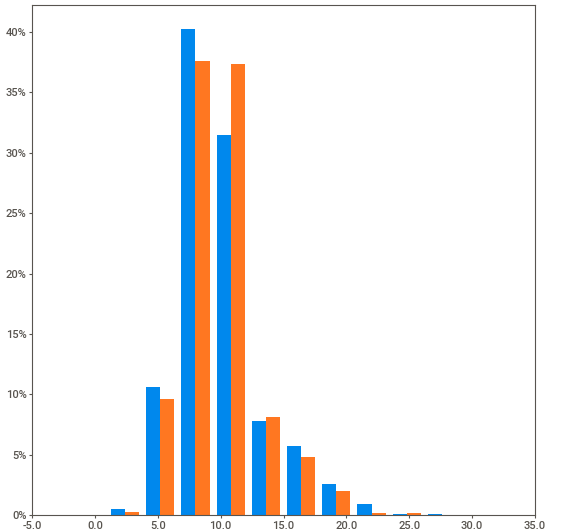
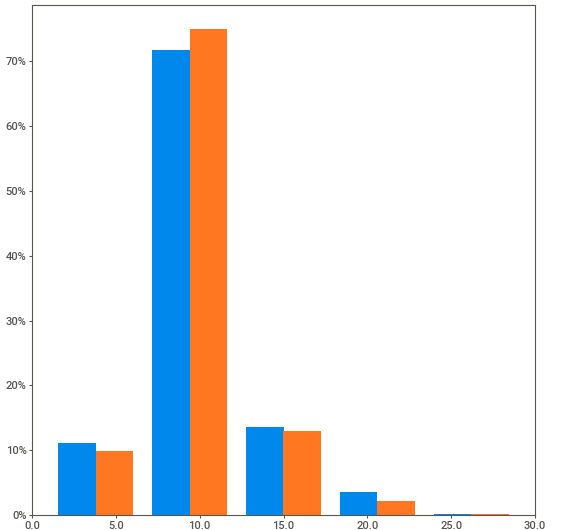
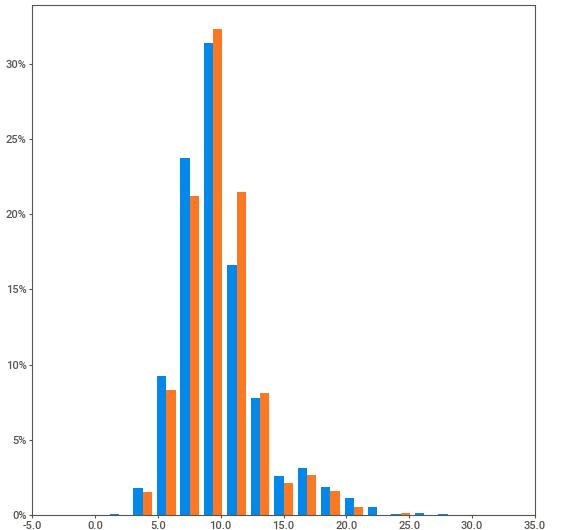
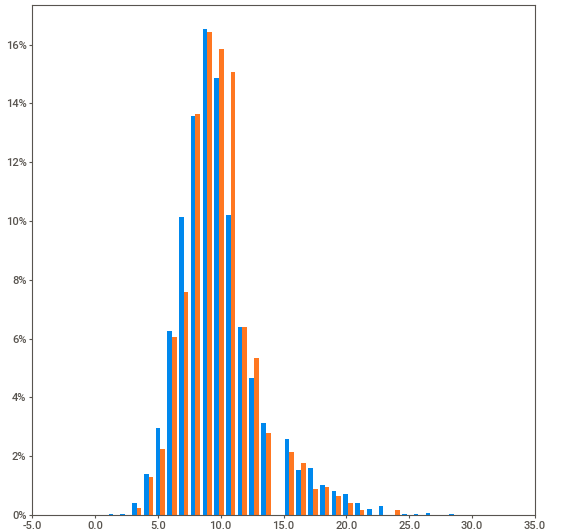
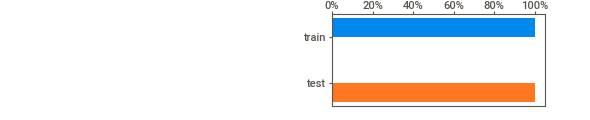
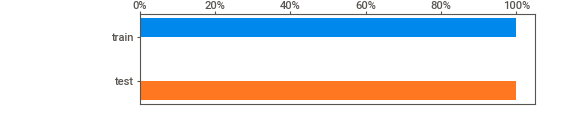
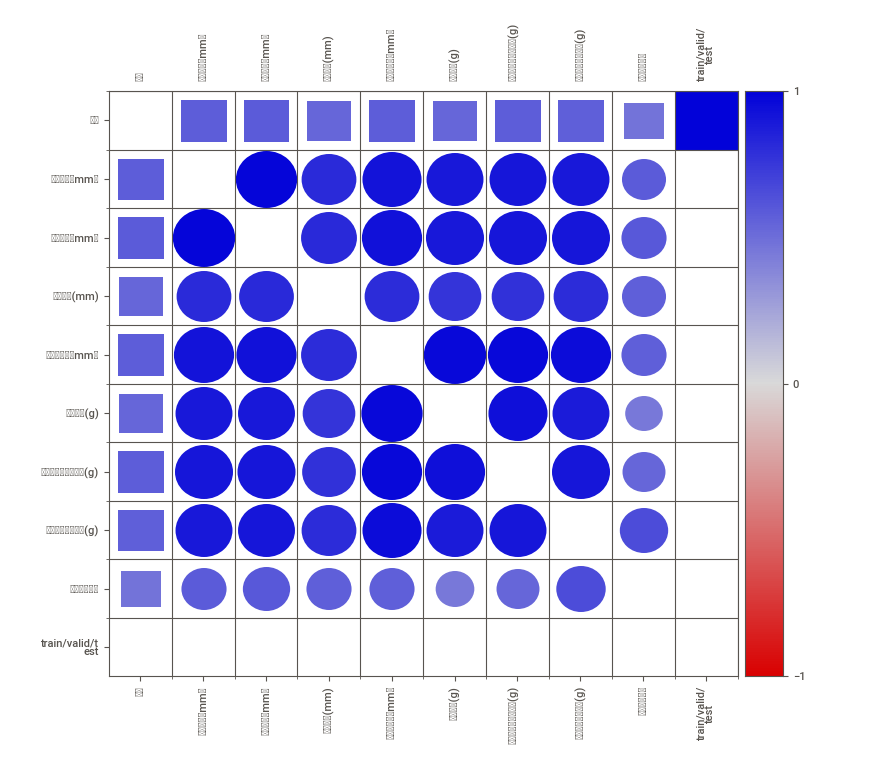
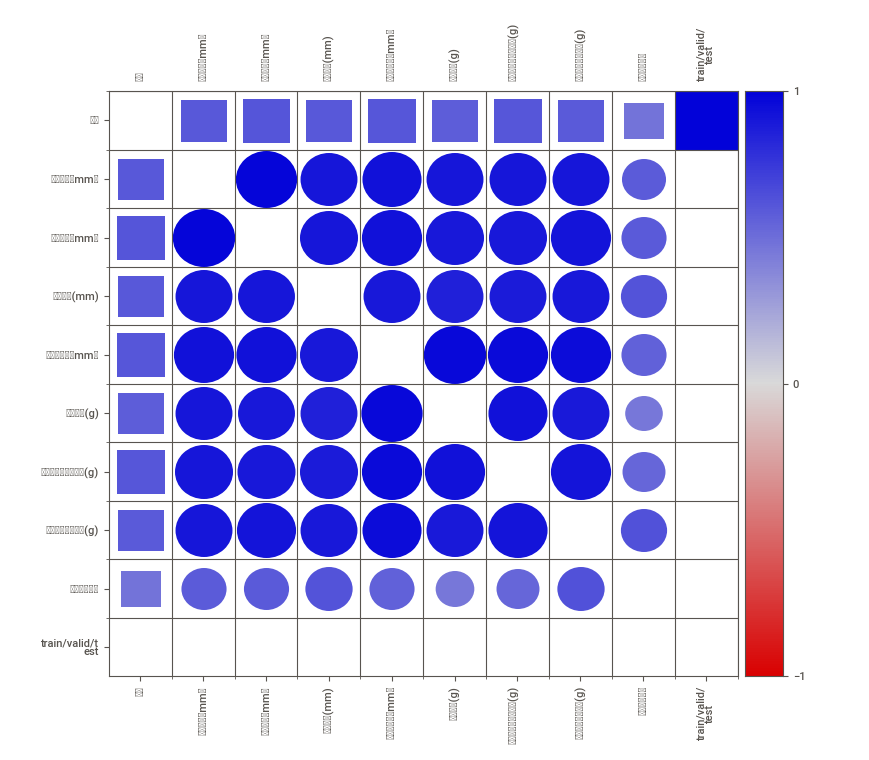

In [ ]:
# 各列の統計量やヒストグラムを可視化
my_report.show_notebook()

In [ ]:
# Adversal Validationによデータ分割
df_concat = pd.concat([df_train, df_test], axis=0)

In [ ]:
len(df_concat)

4177

In [ ]:
# LightGBMによる分類器のインスタンス作成
adv_clf = LGBMClassifier(random_state=1234, # 乱数の固定
                         n_jobs=-1,
                         importance_type="gain")

In [ ]:
X = df_concat.drop(["train/valid/test", "殻の年輪の数"], axis=1)

y = df_concat["train/valid/test"]

adv_clf.fit(X, y, categorical_feature=["性別"])

LGBMClassifier(importance_type='gain', random_state=1234)

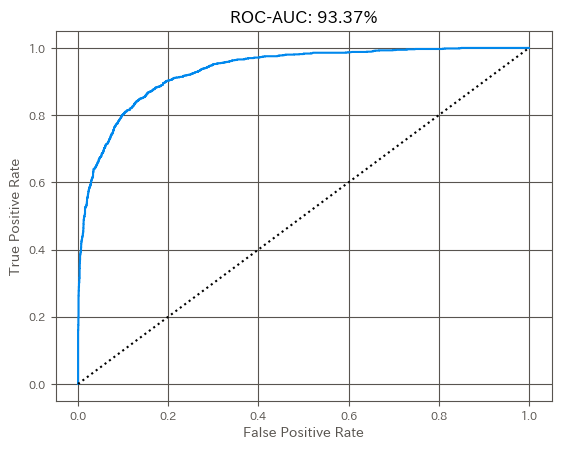

In [ ]:
japanize_matplotlib.japanize()

def plot_auc_curve(adv_clf,
                   X,
                   y,
                   ):
    # テストデータである確率
    y_pred_proba = adv_clf.predict_proba(X)[:, 0]
    
    # ROC曲線の作成
    false_pos_rate, true_pos_rate, _ = roc_curve(y,
                                                 y_pred_proba,
                                                 pos_label="test")
    auc_val = auc(false_pos_rate,
                  true_pos_rate)
    
    plt.plot(false_pos_rate, # 偽陽性率
              true_pos_rate) #　真陽性率

    plt.plot(np.arange(0, 1.1, 0.1),
             np.arange(0, 1.1, 0.1),
             color="black",
             linestyle=":")
    
    plt.grid(True)

    plt.xlabel("False Positive Rate")

    plt.ylabel("True Positive Rate")

    plt.title(f"ROC-AUC: {auc_val:.2%}") # 小数点3桁目を四捨五入

plot_auc_curve(adv_clf, X, y)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

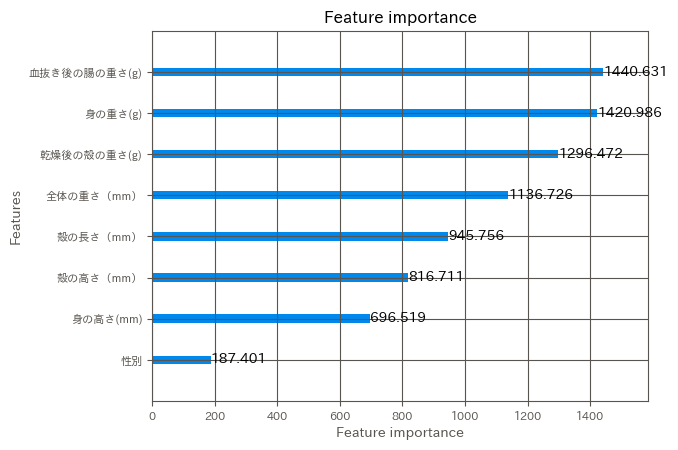

In [ ]:
# 重度度の可視化
lgb.plot_importance(adv_clf)

In [ ]:
def train_valid_split_using_prob(adv_clf,
                                 X,
                                 y,
                                 df_train,
                                 valid_size=0.2
                                 ):
    y_pred_proba = adv_clf.predict_proba(X[y == "train"])[:, 0]

    valid_data_num = int(len(df_train) * valid_size)

    idx = np.argsort(y_pred_proba)[::-1][:valid_data_num]

    df_train.loc[idx, "train/valid/test"] = "valid"

    return df_train

In [ ]:
df_train_new = train_valid_split_using_prob(adv_clf, X, y, df_train)

In [ ]:
df_train_new[df_train_new["train/valid/test"] == "valid"]

,性別,殻の長さ（mm）,殻の高さ（mm）,身の高さ(mm),全体の重さ（mm）,身の重さ(g),血抜き後の腸の重さ(g),乾燥後の殻の重さ(g),殻の年輪の数,train/valid/test
1,2.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,valid
7,0.0,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,16,valid
8,2.0,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.1650,9,valid
11,2.0,0.430,0.350,0.110,0.4060,0.1675,0.0810,0.1350,10,valid
14,0.0,0.470,0.355,0.100,0.4755,0.1675,0.0805,0.1850,10,valid
...,...,...,...,...,...,...,...,...,...,...
2910,2.0,0.580,0.445,0.150,0.9525,0.4315,0.1945,0.2870,11,valid
2913,2.0,0.590,0.500,0.150,1.1420,0.4850,0.2650,0.3450,9,valid
2914,1.0,0.590,0.460,0.125,0.7550,0.3340,0.1500,0.2380,9,valid
2915,1.0,0.590,0.475,0.145,0.9745,0.4675,0.2070,0.2590,10,valid


In [ ]:
# ハイパラ調整
df_train_random, df_valid_random = train_test_split(df_train, test_size=0.2, random_state=1234)

In [ ]:
df_train_adv = df_train_new[df_train_new["train/valid/test"] == "train"]
df_valid_adv = df_train_new[df_train_new["train/valid/test"] == "valid"]

In [ ]:
def lgbm_train(df_train,
               df_valid):
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    X_train = df_train.drop(["殻の年輪の数", "train/valid/test"], axis=1)

    y_train = df_train["殻の年輪の数"]

    X_valid = df_valid.drop(["殻の年輪の数", "train/valid/test"], axis=1)

    y_valid = df_valid["殻の年輪の数"]

    train_set = lgb_opt.Dataset(X_train,
                                label=y_train,
                                categorical_feature=["性別"])
    valid_set = lgb_opt.Dataset(X_valid,
                                label=y_valid,
                                categorical_feature=["性別"])
    
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1, # ログ出力をオフ
        "random_state": 1234
    }

    with np.errstate(under="ignore"):
        tuned_model = lgb_opt.train(params,
                                    valid_set,
                                    valid_sets=valid_set,
                                    verbose_eval=False,
                                    num_boost_round=100,
                                    show__progress_bar=False,
                                    optuna_seed=1234
                                    )
    tuned_params = tuned_model.params

    X = pd.concat([X_train, X_valid], axis=0)

    y = pd.concat([y_train, y_valid], axis=0)

    final_model = LGBMRegressor(random_state=1234,
                                n_jobs=-1).set_params(**tuned_param)
    final_model.fit(X, y)

    return final_model


In [ ]:
tuned_model_random = lgbm_train(df_train_random, df_valid_random)

tuned_model_adv = lgbm_train(df_train_adv, df_valid_adv)

TypeError: ignored